In [42]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


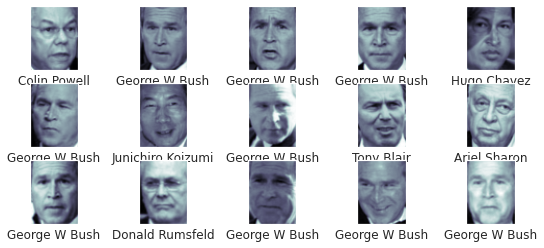

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
fig, ax = plt.subplots(3,5)
fig.subplots_adjust(left=0.0625, right=1.2, wspace=1)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [44]:
#使用预处理来提取更有意义的特征。这里使用主成份分析来提取150个基本元素，然后将其提供给支持向量机分类器。
#将这个预处理和分类器打包成管道

from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

#为了测试分类器的训练效果，将数据集分解成训练集和测试集进行交叉检验
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42)

#用网络搜索交叉检验来寻找最优参数组合。通过不断调整C（松弛变量）和参数gamma（控制径向基函数核的大小），确定最优模型

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1,5,10,50], 'svc__gamma':[0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

grid.fit(x_train, y_train)
print(grid.best_params_)

{'svc__C': 10, 'svc__gamma': 0.001}


Text(0.5, 0.98, 'Predicted Names; Incorect Lables in Red')

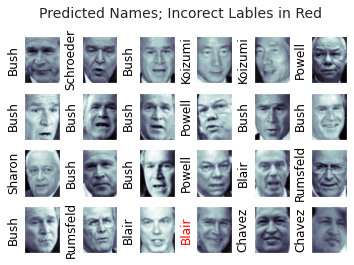

In [45]:
#有了交叉检验的模型，现在就可以对测试集的数据进行预测了
model = grid.best_estimator_
y_fit = model.predict(x_test)
#比较预测结果和真实结果
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                  color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorect Lables in Red', size=14)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 80 eigenfaces from 966 faces
done in 0.589s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
Fitting the classifier to the training set
done in 13.881s
Best estimator found by grid search:
SVC(C=1, class_weight='balanced', gamma=0.01)
[ 61 165  88 353  83  56 103]
Predicting people's names on the test set
done in 0.050s
                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.69      0.78        13
     Colin Powell       0.87      0.92      0.89        60
  Donald Rumsfeld       0.71      0.63      0.67        27
    George W Bush       0.91      0.95      0.93       146
Gerhard Schroeder       0.68      0.76      0.72        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.88      0.81      0.84        36

         accuracy         

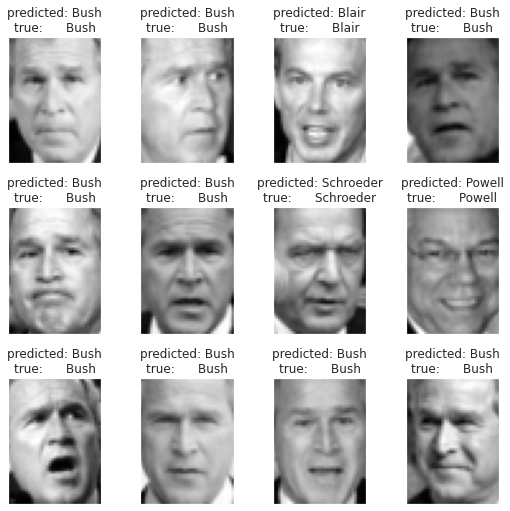

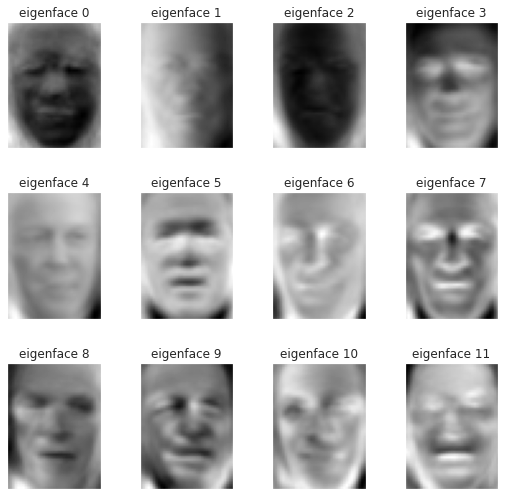

In [35]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 80

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1,10, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print(clf.best_estimator_.n_support_)
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Show the feature face
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()
